# EDA1

Analysis on weekly usage csv

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


file_path = "/Users/gabriel/Downloads/LinkNYC_Weekly_Usage__Updated__20251008.csv"
df = pd.read_csv(file_path)

df["week_end"] = pd.to_datetime(df["Report Ending (weekly starting on Sundays)"], errors="coerce")
df = df.sort_values("week_end").reset_index(drop=True)

def to_minutes(t):
    try:
        h, m, s = map(int, t.split(":"))
        return h * 60 + m + s / 60
    except:
        return np.nan

df["Avg_Session_Minutes"] = df["Average Session Length"].apply(to_minutes)


df["week_diff"] = df["week_end"].diff().dt.days
missing_weeks = df.loc[df["week_diff"] > 7, ["week_end", "week_diff"]]


key_metrics = ["Number of Sessions", "Number of Unique Clients", "TB Downloaded", "TB Uploaded"]
outliers = {}

for col in key_metrics:
    q1, q3 = df[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    outliers[col] = df[(df[col] < lower) | (df[col] > upper)][["week_end", col]]


summary = {
    "missing_weeks_count": len(missing_weeks),
    "missing_weeks": missing_weeks.head(5),
    "outlier_counts": {k: len(v) for k, v in outliers.items()},
    "null_values": df[key_metrics + ["Avg_Session_Minutes"]].isna().sum().to_dict()
}

print("=== DATA QUALITY SUMMARY ===")
print(f"Missing weeks: {summary['missing_weeks_count']}")
print(f"Outlier counts: {summary['outlier_counts']}")
print(f"Missing values: {summary['null_values']}")
print("\nSample missing weeks:\n", summary["missing_weeks"])



=== DATA QUALITY SUMMARY ===
Missing weeks: 3
Outlier counts: {'Number of Sessions': 17, 'Number of Unique Clients': 14, 'TB Downloaded': 3, 'TB Uploaded': 0}
Missing values: {'Number of Sessions': 0, 'Number of Unique Clients': 0, 'TB Downloaded': 0, 'TB Uploaded': 0, 'Avg_Session_Minutes': 0}

Sample missing weeks:
       week_end  week_diff
91  2021-10-04        8.0
125 2022-05-30        8.0
232 2024-06-19       10.0


year
2020     85.992885
2021     69.050192
2022    104.693846
2023    143.979811
2024    152.977500
2025    112.645385
Name: TB Downloaded, dtype: float64
year
2020     7.605577
2021     8.780769
2022    17.145962
2023    22.737925
2024    23.944423
2025    18.106667
Name: TB Uploaded, dtype: float64


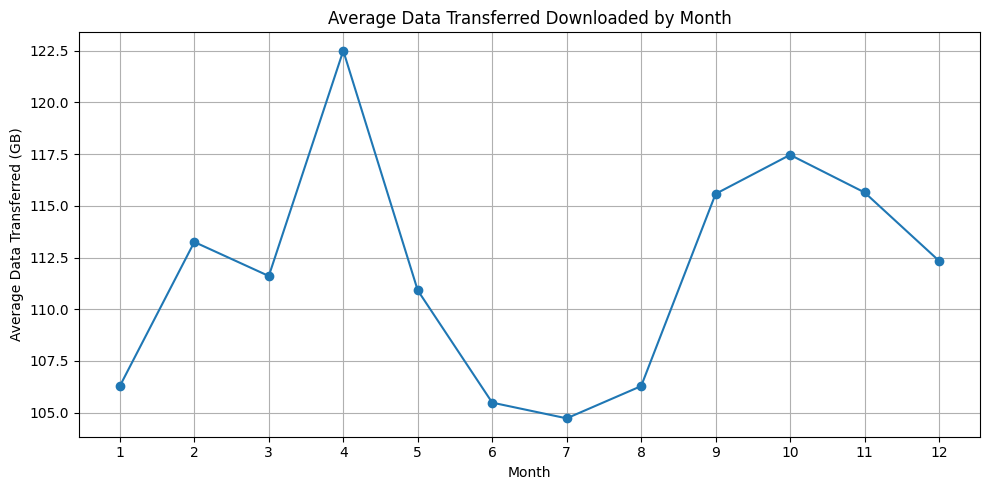

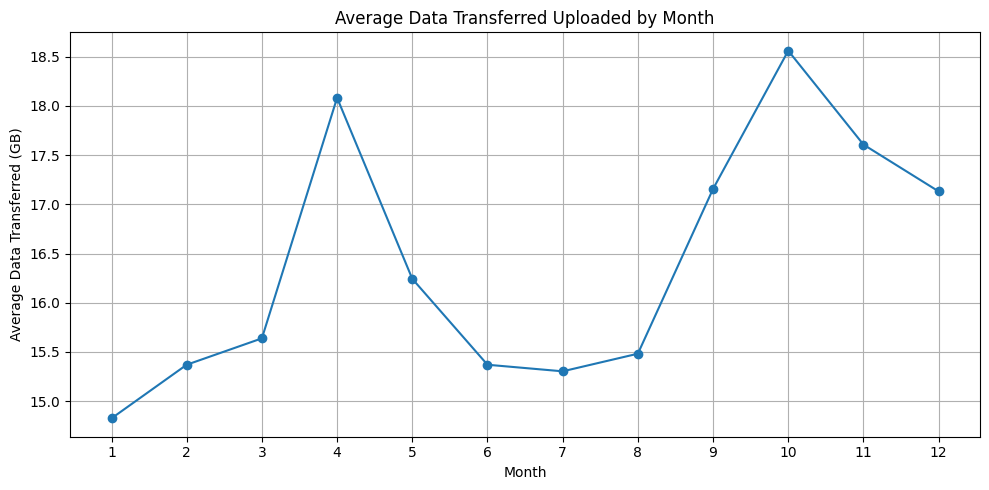

year
2020     5.247756
2021     9.126923
2022    22.907692
2023    23.456918
2024    30.767628
2025    32.544444
Name: Avg_Session_Minutes, dtype: float64


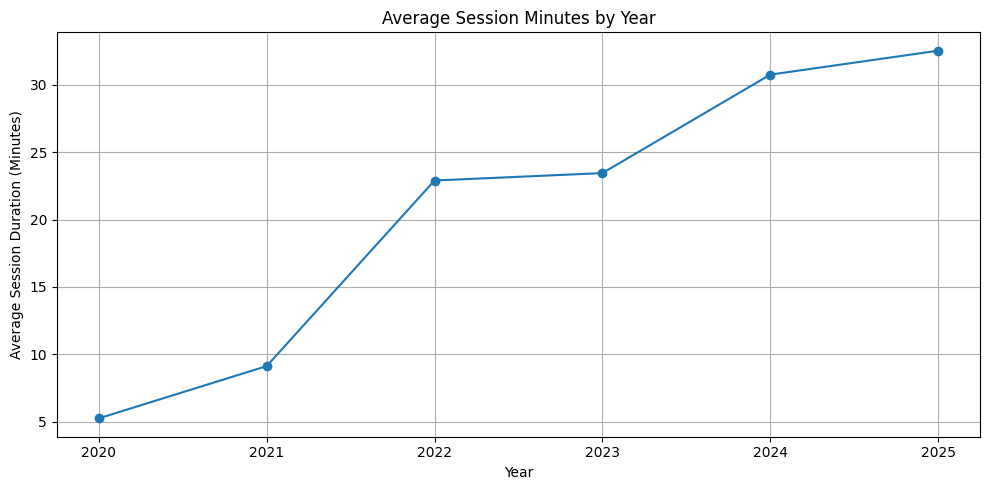

    month  Number of Sessions
0       1           185491907
1       2           173253287
2       3           176638628
3       4           121025385
4       5           133637272
5       6           128657799
6       7           129591126
7       8           146390367
8       9           137801692
9      10           113076233
10     11           102686724
11     12           100428682


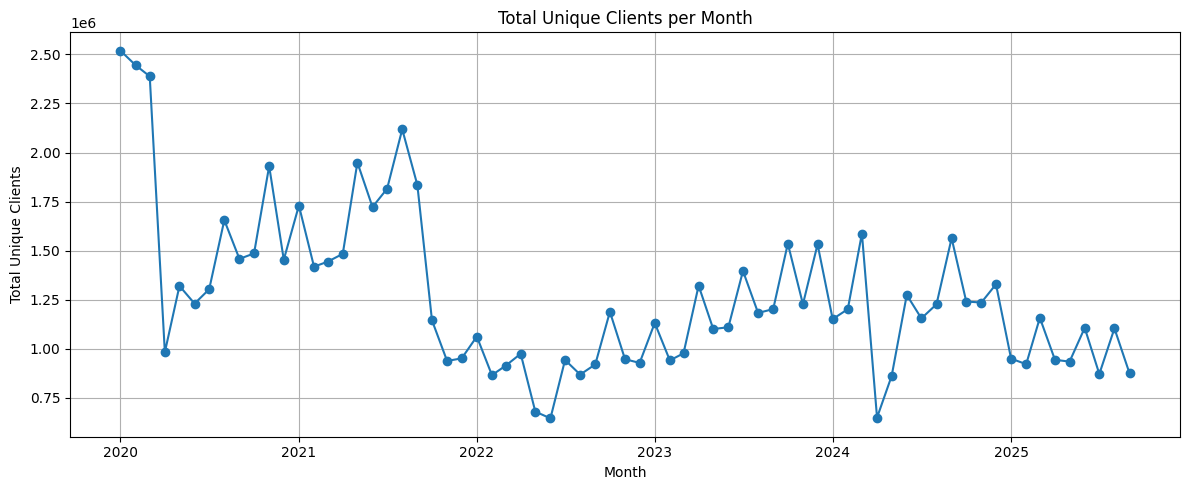

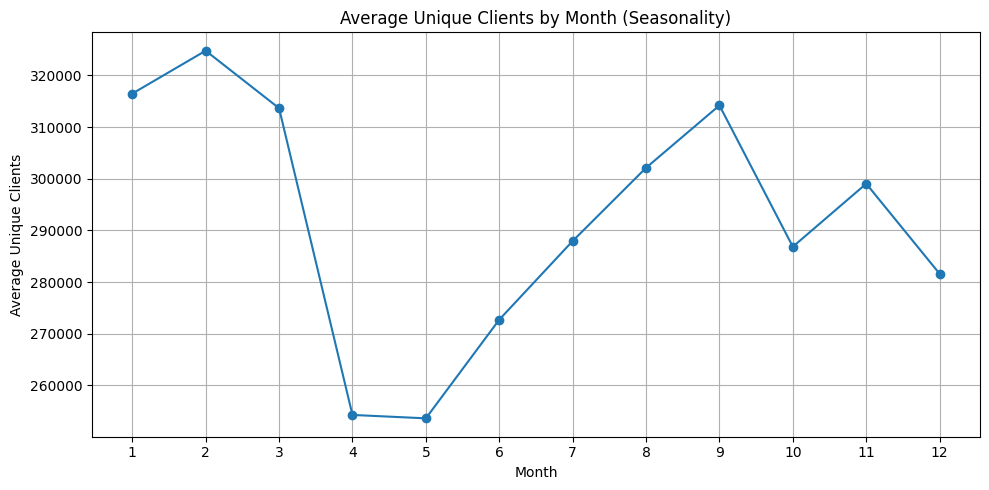

In [ ]:
df['date'] = df["week_end"] 
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['week'] = df['date'].dt.isocalendar().week
df['dayofweek'] = df['date'].dt.dayofweek  # 0=Monday
df['quarter'] = df['date'].dt.quarter
print(df.groupby('year')['TB Downloaded'].mean())
print(df.groupby('year')['TB Uploaded'].mean())
df.groupby(['year', 'week'])['TB Downloaded'].mean().reset_index()
monthly_avg = df.groupby('month')['TB Downloaded'].mean()
plt.figure(figsize=(10, 5))
plt.plot(monthly_avg.index, monthly_avg.values, marker='o', linestyle='-')
plt.title('Average Data Transferred Downloaded by Month')
plt.xlabel('Month')
plt.ylabel('Average Data Transferred (GB)')
plt.xticks(range(1, 13))  # Ensure x-axis shows months 1 to 12
plt.grid(True)
plt.tight_layout()
plt.show()
monthly_avg_upl = df.groupby('month')['TB Uploaded'].mean()
plt.figure(figsize=(10, 5))
plt.plot(monthly_avg_upl.index, monthly_avg_upl.values, marker='o', linestyle='-')
plt.title('Average Data Transferred Uploaded by Month')
plt.xlabel('Month')
plt.ylabel('Average Data Transferred (GB)')
plt.xticks(range(1, 13))  
plt.grid(True)
plt.tight_layout()
plt.show()
average_session_year = df.groupby('year')['Avg_Session_Minutes'].mean()
print(average_session_year)
plt.figure(figsize=(10, 5))
plt.plot(average_session_year.index, average_session_year.values, marker='o', linestyle='-')
plt.title('Average Session Minutes by Year')
plt.xlabel('Year')
plt.ylabel('Average Session Duration (Minutes)')
plt.grid(True)
plt.tight_layout()
plt.show()
monthly_sessions = df.groupby(['month'])['Number of Sessions'].sum().reset_index()
print(monthly_sessions)

monthly_clients = df.groupby(['year', 'month'])['Number of Unique Clients'].sum().reset_index()
# Creating a datetime column for plotting
monthly_clients['year_month'] = pd.to_datetime(monthly_clients[['year', 'month']].assign(day=1))
plt.figure(figsize=(12, 5))
plt.plot(monthly_clients['year_month'], monthly_clients['Number of Unique Clients'], marker='o')
plt.title('Total Unique Clients per Month')
plt.xlabel('Month')
plt.ylabel('Total Unique Clients')
plt.grid(True)
plt.tight_layout()
plt.show()
monthly_avg_clients = df.groupby('month')['Number of Unique Clients'].mean()
plt.figure(figsize=(10, 5))
plt.plot(monthly_avg_clients.index, monthly_avg_clients.values, marker='o')
plt.title('Average Unique Clients by Month (Seasonality)')
plt.xlabel('Month')
plt.ylabel('Average Unique Clients')
plt.xticks(range(1, 13))
plt.grid(True)
plt.tight_layout()
plt.show()











# EDA2

# 🗽 <span style="color:blue;">NYC</span> <span style="color:white;">EDA &</span> <span style="color:orange;"> Features</span> 🛜

## <span style="color:white;">Initializing Libraries</span>

In [22]:
import datetime as dt
import geopandas as gpd
from geodatasets import get_path
import seaborn as sns

df = pd.read_csv('/Users/gabriel/Desktop/marcy/Mod-5-Project/LinkNYC_Kiosk_Locations_20251008.csv')
df = pd.DataFrame(df)
df2=pd.read_csv('/Users/gabriel/Desktop/marcy/Mod-5-Project/LinkNYC_Weekly_Usage__Updated__20251008.csv')
df2=pd.DataFrame(df2)

## <span style="color:blue;">Exploratory Data Analysis</span>

In [23]:
# See data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2250 entries, 0 to 2249
Data columns (total 23 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Site ID                               2250 non-null   object 
 1   Planned Kiosk Type                    2250 non-null   object 
 2   Installation Status                   2250 non-null   object 
 3   PPT ID                                2102 non-null   object 
 4   Legacy ID                             2055 non-null   object 
 5   Borough                               2250 non-null   object 
 6   Council District                      2250 non-null   int64  
 7   Community Board                       2250 non-null   int64  
 8   Street Address                        2250 non-null   object 
 9   Cross Street 1                        2246 non-null   object 
 10  Cross Street 2                        2246 non-null   object 
 11  IxN Corner       

In [24]:
print(df['Site ID'].duplicated().sum()) # Check duplicates

0


In [25]:
df.groupby('Borough')['Installation Status'].value_counts() # Kiosk Installation Status by Borough

Borough        Installation Status      
Bronx          Live                          214
               Removed Pending Reinstall       2
Brooklyn       Live                          355
               Removed Pending Reinstall       1
Manhattan      Live                         1224
               Removed Pending Reinstall       6
Queens         Live                          394
               Removed Pending Reinstall       4
Staten Island  Live                           50
Name: count, dtype: int64

In [26]:
df['Planned Kiosk Type'] = df['Planned Kiosk Type'].str.title() # Link1.0 was also listed as LINK1.0 which slightly affected counts
df.groupby('Borough')['Planned Kiosk Type'].value_counts() # Note : Interesting that Manhattan still has payphones.

Borough        Planned Kiosk Type
Bronx          Link1.0                186
               Link5G_Ad               26
               Link5G_Nonad             4
Brooklyn       Link1.0                299
               Link5G_Ad               36
               Link5G_Nonad            21
Manhattan      Link1.0               1206
               Link5G_Ad               17
               Public Payphones         4
               Link5G_Nonad             3
Queens         Link1.0                308
               Link5G_Ad               63
               Link5G_Nonad            27
Staten Island  Link1.0                 42
               Link5G_Ad                8
Name: count, dtype: int64

In [27]:
# Convert Activation Date and Installation Date into datetimes
df['Activation Complete'] = pd.to_datetime(df['Activation Complete'])
df['Installation Complete'] = pd.to_datetime(df['Installation Complete'])

# See how long the wait in between Installation and Activation
df['Activation Wait'] = (df['Activation Complete'] - df['Installation Complete'])

# Average Wait between Installation and Activation between Boroughs
df.groupby('Borough')['Activation Wait'].mean()


Borough
Bronx                      79 days 23:46:40
Brooklyn        104 days 08:37:45.168539326
Manhattan       113 days 20:37:27.804878048
Queens           99 days 07:46:44.020100503
Staten Island              61 days 16:48:00
Name: Activation Wait, dtype: timedelta64[ns]

## <span style="color:antiquewhite;">Visuals</span>

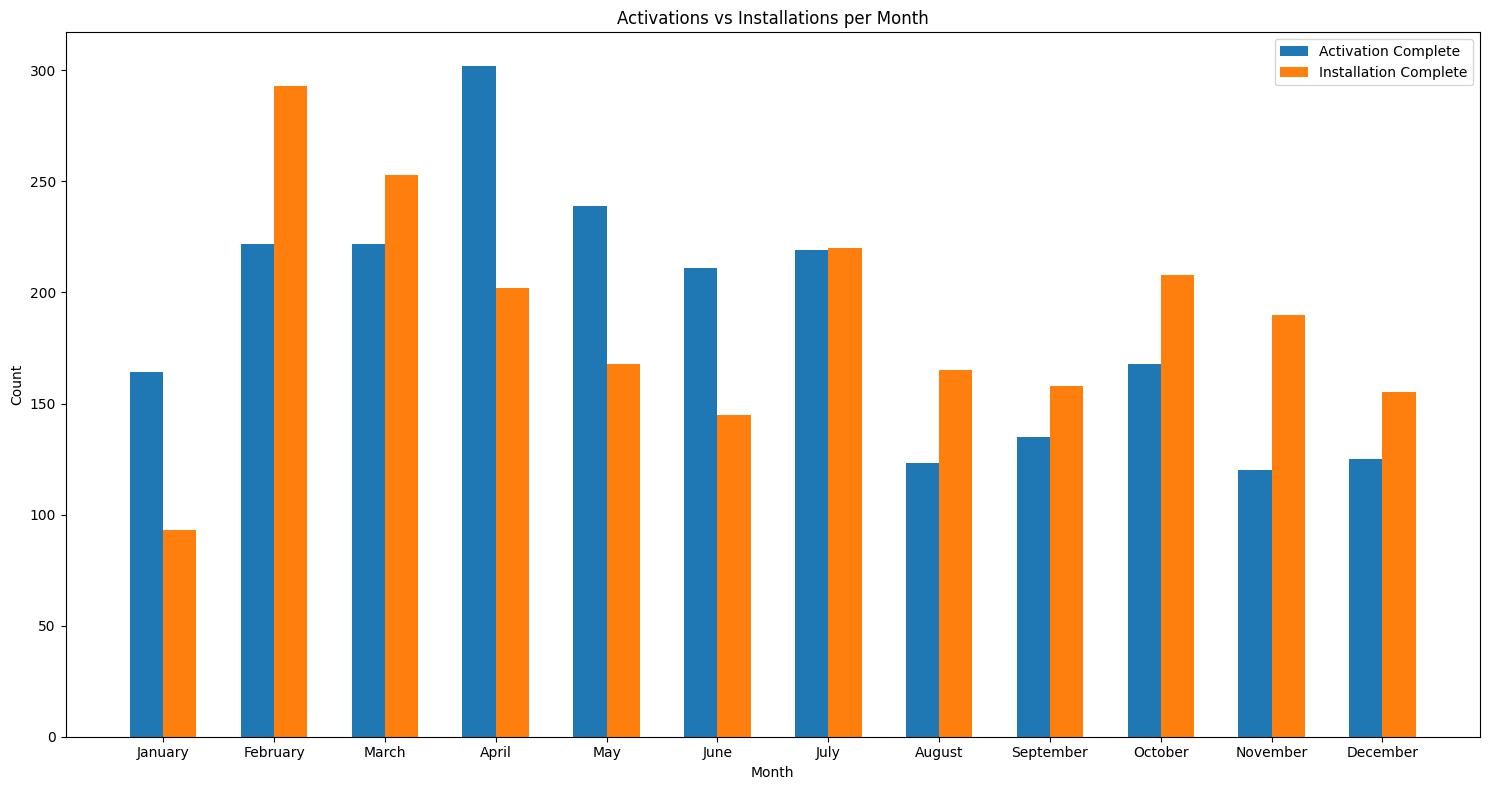

In [28]:

# Convert to month names
month = df['Activation Complete'].dt.month_name()
month2 = df['Installation Complete'].dt.month_name()

# Count 
month_counts = month.value_counts()
month2_counts = month2.value_counts()

# Chronological month order
month_order = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]

# Reindex counts to follow calendar order
month_counts = month_counts.reindex(month_order)
month2_counts = month2_counts.reindex(month_order)

# Bar setup

x = np.arange(len(month_order))

plt.figure(figsize=(15, 8))
plt.bar(x - .3/2, month_counts, width=.3, label='Activation Complete')
plt.bar(x + .3/2, month2_counts, width=.3, label='Installation Complete')

# Labels and formatting
plt.xticks(x, month_order)
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Activations vs Installations per Month')
plt.legend()
plt.tight_layout()
plt.show()


Extracting 'nybb_16a/nybb.shp' from '/Users/gabriel/Library/Caches/geodatasets/nybb_16a.zip' to '/Users/gabriel/Library/Caches/geodatasets/nybb_16a.zip.unzip'
Extracting 'nybb_16a/nybb.shx' from '/Users/gabriel/Library/Caches/geodatasets/nybb_16a.zip' to '/Users/gabriel/Library/Caches/geodatasets/nybb_16a.zip.unzip'
Extracting 'nybb_16a/nybb.dbf' from '/Users/gabriel/Library/Caches/geodatasets/nybb_16a.zip' to '/Users/gabriel/Library/Caches/geodatasets/nybb_16a.zip.unzip'
Extracting 'nybb_16a/nybb.prj' from '/Users/gabriel/Library/Caches/geodatasets/nybb_16a.zip' to '/Users/gabriel/Library/Caches/geodatasets/nybb_16a.zip.unzip'


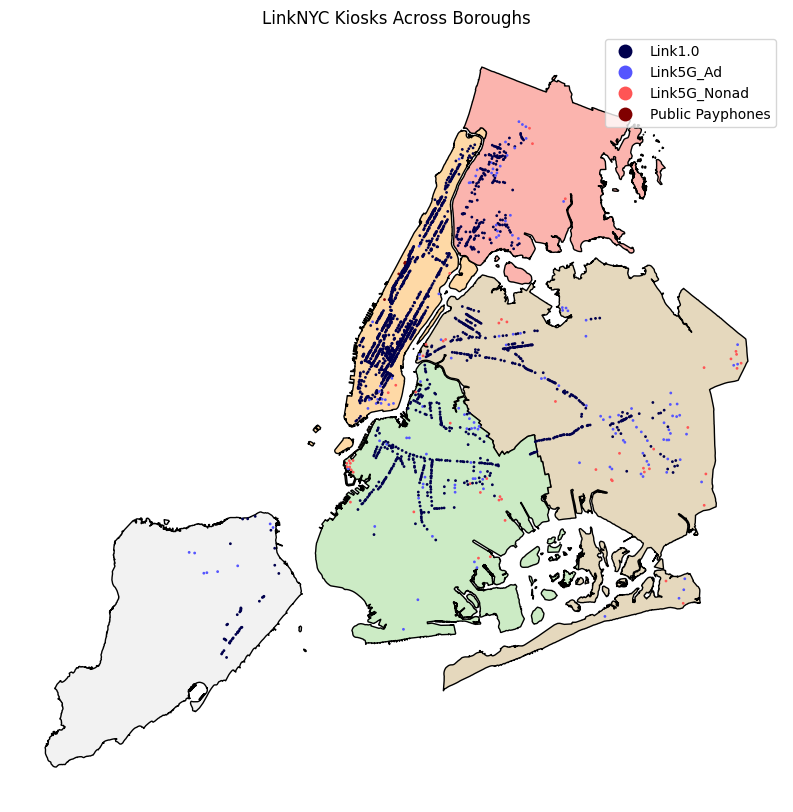

In [29]:
# Define GeoDataFrame.
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude), crs="EPSG:4326"
)
world = gpd.read_file(get_path("naturalearth.land"))

# We restrict to NYC. Convert boroughs to same (Coordinate Reference Systems)CRS as your data.
nyc = gpd.read_file(get_path("nybb"))
nyc = nyc.to_crs(epsg=4326)

# Set axes
ax = nyc.plot(
    column="BoroName",    
    figsize=(10,10),
    edgecolor="black",
    cmap = 'Pastel1')

gdf.plot(ax=ax, markersize = 1, column='Planned Kiosk Type', categorical=True,legend='True', cmap = 'seismic')

plt.title('LinkNYC Kiosks Across Boroughs')

plt.axis('off')
plt.show()

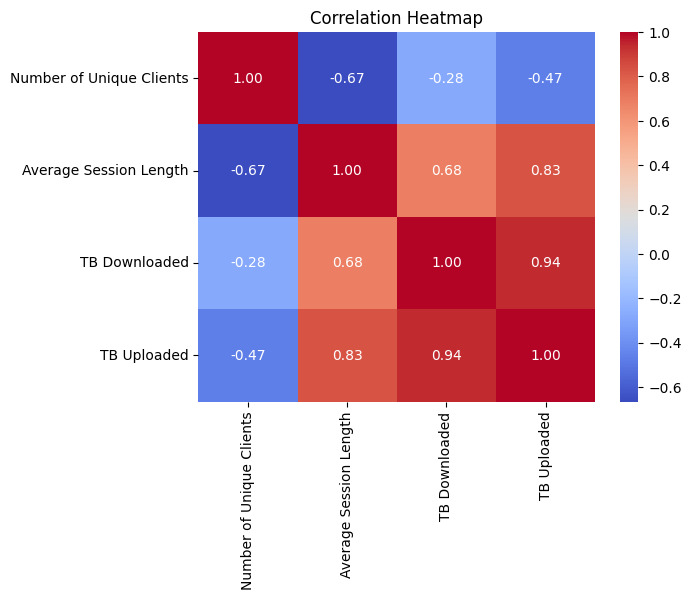

In [32]:
## Correlation heatmap
df2["Average Session Length"] = pd.to_timedelta(df2["Average Session Length"]).dt.total_seconds()
numeric_cols = ["Number of Unique Clients", "Average Session Length", "TB Downloaded", "TB Uploaded"]
corr = df2[numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


## <span style="color:orange;">Features</span>

In [ ]:
# Features
# --------------------------------------------------------------------------------
# Combines TB Downloaded and TB Uploaded to get Total TB. 
# This helps clearly see how much data is going through the kiosk each week.

df2['Total TB'] = df2['TB Downloaded'] + df2['TB Uploaded']
# --------------------------------------------------------------------------------

# --------------------------------------------------------------------------------
# Converts TB to GB.
#  This feature makes the data more suitable for calculations, as instead of getting small decimals, we will get more full numbers.

df2['GB Downloaded'] = 1000 * df2['TB Downloaded']
df2['GB Uploaded'] = 1000 * df2['TB Uploaded'] 
df2['Total GB'] = 1000 * df2['Total TB']
# --------------------------------------------------------------------------------

# --------------------------------------------------------------------------------
# If Average GB per session is above activation threshold, heavy_usage_week = 1.
# This flags weeks where there is a lot of usage throughout a week.
df2['heavy_usage_week'] = (df2['Total GB'] / df2['Number of Sessions'] > 0.04).astype(int)
# --------------------------------------------------------------------------------

# --------------------------------------------------------------------------------
# Creates a list of summer months then a binary field (is_summer), indicating whether the months are in the summer list. 
# This flags which Reports were in the summer, making it easier for a Stakeholder to see how a kiosk performs during the season that it is most likely to be used.

df2['Report Months'] = df2['Report Ending (weekly starting on Sundays)'].dt.month_name()

summer = ['June', 'July', 'August']
df2['is_summer'] = df2['Report Months'].isin(summer).astype(int)
# --------------------------------------------------------------------------------

# --------------------------------------------------------------------------------
# This feature uses the Zoning code to identify which zone each kiosk is in. 
# With more data, stakeholders can focus on increasing or decreasing the amount of kiosk in a certain area
# An example of how this may help is if we see that Link5G kiosk with ads have more data going through them in commercial zones, we may increase the amount of kiosk in that type of zone.
# C = Commercial Zone
# R = Residential Zone
# M = Manufacturing Zone

firstletter = df['Zoning'].str[0] # Stores first letter of the Zoning

df['is_commercial'] = 0
df['is_residential'] = 0
df['is_manufacturing'] = 0

df.loc[firstletter == 'C', 'is_commercial'] = 1
df.loc[firstletter == 'R', 'is_residential'] = 1
df.loc[firstletter == 'M', 'is_manufacturing'] = 1
# --------------------------------------------------------------------------------

# --------------------------------------------------------------------------------
# A long session is over 25:00 minutes on the Kiosk. 
# This may be helpful to combine with other features to see what causes a customer to stay at a specific kiosk for a longer duration.

df2['Average Session Length'] = pd.to_timedelta(df2['Average Session Length']) # Change from string into TimeDelta
df2['is_long_session'] = 0
df2.loc[df2['Average Session Length'] >= pd.to_timedelta(25, 'm'), 'is_long_session'] = 1 # If session is larger than or equal to 25 minutes, it is considered a "long session"
# --------------------------------------------------------------------------------

# --------------------------------------------------------------------------------
# Flags weeks with a low number of unique users. 
# This shows weeks where the amount of users is unusally low. We can use this flag to identify the issue and fix it accordingly.
df2['is_low_users'] = 0
df2.loc[df2['Number of Unique Clients'] <= 250000, 'is_low_users'] = 1 # If the number of unique clients is under 250000, then it is considers a a week with low unique users. 250000 may seem like a lot, but it is below both the mean, being 292255, and the median, being 273385
# --------------------------------------------------------------------------------

# --------------------------------------------------------------------------------
# This shows how often there are long sessions when there are not a lot of users. A long session is defined by us as over 25 minutes. The range of a LinkNYC Kiosk is stated
# to only be around 150 ft. This implies that there are less people using the kiosk, but the people who are using the kiosk are staying within its radius for at least 25 minutes.
df2['lowuser_longsesh'] = df2['is_low_users'] * df2['is_long_session']
print(df2['lowuser_longsesh'].sum()) # This feature is important because it shows how common there are long sessions when a kiosk does not have a lot of users. 
#This means the kiosk has a few users stationed at the kiosk for a long amount of time rather than a lot of users using the kiosk briefly. 
# --------------------------------------------------------------------------------

ALL KIOSK -> AVAILABLE KIOSK ->

# KPIs

In [ ]:

# Load dataset
usage = pd.read_csv("/Users/gabriel/Downloads/LinkNYC_Weekly_Usage__Updated__20251008.csv")

# --- Derived metrics ---
usage["gb_per_session"] = (
    (usage["TB Downloaded"] + usage["TB Uploaded"]) * 1024 / usage["Number of Sessions"]
).replace([np.inf, -np.inf], np.nan)

usage["sessions_per_user"] = (
    usage["Number of Sessions"] / usage["Number of Unique Clients"]
).replace([np.inf, -np.inf], np.nan)

# --- Activation thresholds ---
Z = usage["gb_per_session"].quantile(0.75)
X = usage["Number of Unique Clients"].median()
Y = usage["Number of Sessions"].median()

# Candidate A (volume-oriented)
usage["activated_A"] = np.where(
    (usage["Number of Unique Clients"] >= X) & (usage["Number of Sessions"] >= Y),
    1,
    0
)

# Candidate B (quality-oriented + chosen)
usage["activated_B"] = np.where(
    (usage["gb_per_session"] >= Z) & (usage["Number of Sessions"] > 0),
    1,
    0
)

# --- Conversion metric ---
median_sessions = usage["Number of Sessions"].median()
high_volume_weeks = usage[usage["Number of Sessions"] >= median_sessions]
conversion_rate = (
    high_volume_weeks["activated_B"].mean()
) 

# --- Retention (1-week and 4-week) ---
usage = usage.sort_values("Report Ending (weekly starting on Sundays)").reset_index(drop=True)
usage["retained_1w"] = usage["activated_B"].shift(-1)
usage["retained_4w"] = usage["activated_B"].shift(-4)

one_week_retention = (
    (usage["activated_B"] & (usage["retained_1w"] == 1)).sum()
    / usage["activated_B"].sum()
)
four_week_retention = (
    (usage["activated_B"] & (usage["retained_4w"] == 1)).sum()
    / usage["activated_B"].sum()
)

# --- Summary metrics ---
summary = {
    "Activation Threshold (GB/session)": round(Z, 2),
    "Conversion (Sessions→Heavy Weeks)": round(conversion_rate, 3),
    "1-week Retention": round(one_week_retention, 3),
    "4-week Retention": round(four_week_retention, 3),
}

print("KPI Summary:")
for k, v in summary.items():
    print(f"{k}: {v}")

KPI Summary:
Activation Threshold (GB/session): 0.04
Conversion (Sessions→Heavy Weeks): 0.1
1-week Retention: 0.253
4-week Retention: 0.133
